In [1]:
import argparse
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

images_path = "images_2022_11_8"
os.makedirs(images_path, exist_ok=True)

args = {
    "n_epochs" : 200,
    "batch_size" : 64,
    "lr" : 0.0002,
    'b1' : 0.5,
    'b2' : 0.999,
    'n_cpu':8,
    'latent_dim' : 100,
    'img_size' : 28,
    'channels':1,
    'sample_interval' : 400,
}
class opt_dic:
    def __init__(self):
        self.n_epochs = args['n_epochs']
        self.batch_size = args['batch_size']
        self.lr = args['lr']
        self.b1 = args['b1']
        self.b2 = args['b2']
        self.n_cpu = args['n_cpu']
        self.latent_dim = args['latent_dim']
        self.img_size = args['img_size']
        self.channels = args['channels']
        self.sample_interval = args['sample_interval']
        

opt = opt_dic() 

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))), # 纯纯是做一个乘积
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True), # 调整负值0梯度的问题
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity


# Loss function
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize(opt.img_size), transforms.ToTensor(), 
             transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=opt.batch_size,
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------



In [7]:
generator= torch.load("G_model.pt")
discriminator = torch.load("D_model.pt")

In [8]:
D_loss = []
G_loss = []

In [10]:

for epoch in range(opt.n_epochs * 2,opt.n_epochs * 3,1):
    
    epoch_D_loss = []
    epoch_G_loss = []
    for i, (imgs, _) in enumerate(dataloader):

        # Adversarial ground truths
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)
        # Configure input
        real_imgs = Variable(imgs.type(Tensor))
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()
        # Sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        # Generate a batch of images
        gen_imgs = generator(z)
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # print(
        #     "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
        #     % (epoch, opt.n_epochs, i, len(dataloader), d_loss.item(), g_loss.item())
        # )
        epoch_D_loss.append(d_loss.item())
        epoch_G_loss.append( g_loss.item())

        batches_done = epoch * len(dataloader) + i
        # print(gen_imgs[0])
        if batches_done % opt.sample_interval == 0:
            save_image(gen_imgs.data[25:50], f"{images_path}/25_50_%d.png" % batches_done, nrow=5, normalize=True)
    epoch_G_loss = np.array(epoch_G_loss)
    epoch_D_loss = np.array(epoch_D_loss)
    D_loss.append(np.mean(epoch_D_loss))
    G_loss.append(np.mean(epoch_G_loss))



KeyboardInterrupt: 

In [16]:
torch.save(discriminator,"D_model.pt")
torch.save(generator,"G_model.pt")

In [ ]:
print(D_loss)

In [17]:
import pickle
file1 = open("D_loss.pkl","wb") # 这个打开方式有一定可能会影响pickle的成功与否
file2 = open("G_loss.pkl","wb")
pickle.dump(D_loss,file1)
pickle.dump(G_loss,file2)

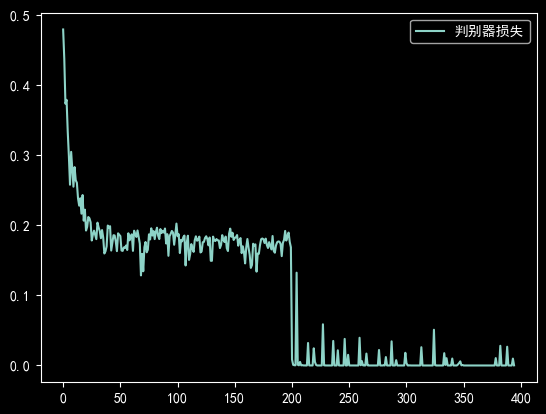

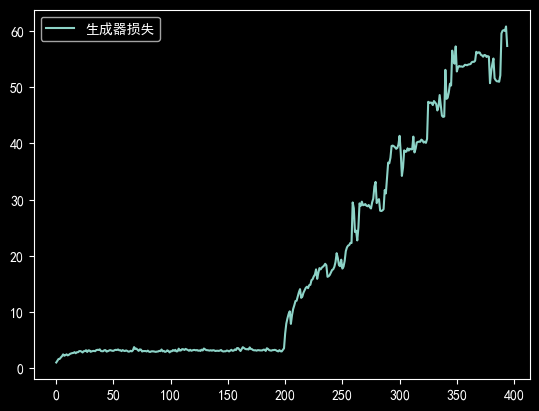

In [19]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
i = [ t for t in range(len(D_loss))]
plt.plot(i,D_loss,label = '判别器损失')
plt.legend()
plt.show()
plt.plot(i,G_loss,label = '生成器损失')
plt.legend()
plt.show()